# <center> <font style="color:rgb(100,109,254)"> Pedestrian Detection with HOG+SVM</font> </center>

In the previous section we have learned how to make an image classifier, now in this notebook we'll expand on that and make an Object detector. Now what we will be making is a Traditional Object Detector, at the heart of this detector is the same classifier we created in the previous notebook, so lets first create a classifier.

For this notebook we'll be detecting if there's a pedestrian present on the image or not and where its bounding box coordinates are it, so first we have to create a binary classifier which satisfies the classification part. This classification pipeline will be almost the same as the previous one.

In [1]:
## Import neccessary packages 

import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from sklearn import svm
from tqdm import tqdm_notebook as tqdm
from random import shuffle
import itertools

So the data for Pedestrians we're using is **INRIA’s Pedestrian dataset**. This dataset contains training and testing images of pedestrians with the size of 64x128 both positive and negative examples. Positive images are the ones in which pedestrians are present *(we will call this Positive class)* and negative images are the ones in which the pedestrians are not present (*we will call this negative class*).

## <font style="color:rgb(134,19,348)"> Visualize the Data  </font>
Its really important that you get an Idea of how the data Looks.here you can se the negative images are represented by 0 and positive by 1.

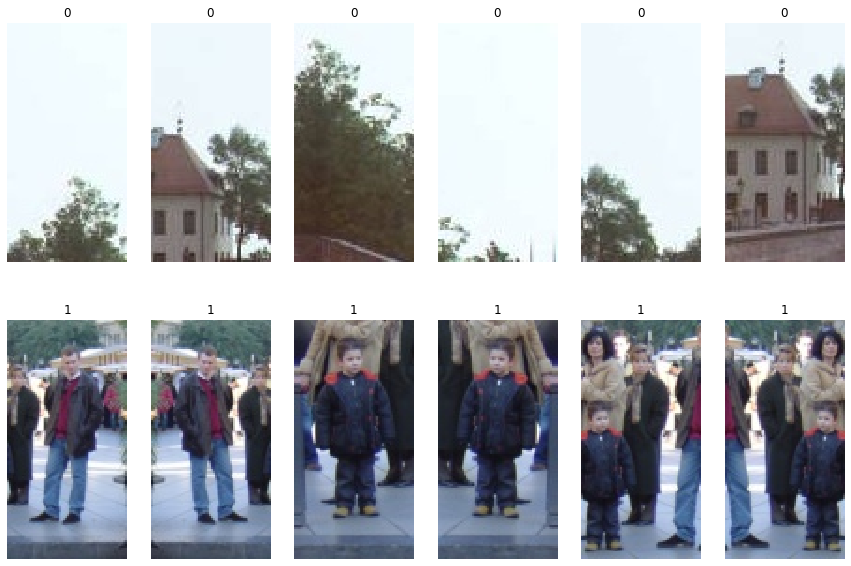

In [2]:
# Path for our training data.
training_path = 'Media/M4/INRIAPerson/train_64x128_H96' 

# The names of our image classes are the names of sub folders.
train_classes = [directory for directory in os.listdir(training_path) if os.path.isdir(os.path.join(training_path,directory))]

plt.figure(figsize=[15,10])

rows = len(train_classes)

Img_no = 1
for class_name in train_classes:    
        img_list = os.listdir( os.path.join(training_path, class_name))[:6]
        for img in img_list:
            draw_image = cv2.imread(os.path.join(training_path, class_name, img),1)
            plt.subplot(rows, 6, Img_no);plt.imshow(draw_image[:,:,::-1]);plt.title(class_name);plt.axis('off');
            Img_no += 1

## <font style="color:rgb(134,19,348)">  Initialize Hog Descriptor </font>

You can use `cv2.HOGDescriptor()`to initialize the hog descriptor. 

In [3]:
# Initialize hog parameters.
winSize = (64, 128) 
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
derivAperture = 1     # Has no effect 
winSigma = -1         # Going to be equal to 4
histogramNormType = 0 # h=Has no effect 
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64 
signedGradient = False

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, histogramNormType, 
                        L2HysThreshold, gammaCorrection, nlevels, signedGradient)

## <font style="color:rgb(134,19,348)">Extract Descriptors and Assign Labels  </font>
Here `1` label to positive class and `0` label to negative class, we can also choose to give them names, but since its a binary class problem, its better this way.

In [4]:
train_classes

['0', '1']

**Here is our Feature extractor function.**

Here we are extracting the features from images and computing its HOG descriptors.

In [5]:
def getfeaturevectors(path, classes,  start_index = 0):
    # This list will hold the final feature vectors.
    Hog_feature_vectors = []
    n_Hog_feature_vectors= []
    
    # This list will hold the labels for each image.
    labels = []
    n_labels= []
    
    # This loop loops for each class (in total we have 29 classes for this dataset), we're also using tqdm for a progress bar.
    for class_label in tqdm(range(len(classes))):

            # This loop loops for each sample in each class (each class have approximately)
            for img in tqdm(os.listdir(os.path.join(path, classes[class_label]))[start_index:]):

                # Read the image
                image = cv2.imread(os.path.join(path, classes[class_label], img))

                # Resize the image, if the image is corrupted then leave it 
                try:
                    image = cv2.resize(image, (64, 128))
                    
                except:
                    #print('Error Readimg image {}'.format(os.path.join(path,classes[i], j)))
                    continue
                
                # Compute the descriptor            
                descriptor = hog.compute(image)

                # Store the feature vector and the label
                Hog_feature_vectors.append(descriptor)
                
                # Also store the label for each class
                labels.append(int(classes[class_label]))
                
    # Formatting labels as required.      
    n_labels = np.array(labels)
    
    # Formating hog feature vectors as required.
    n_Hog_feature_vectors = np.float32(Hog_feature_vectors).reshape(-1, len(Hog_feature_vectors[0]))
    
    # Print the total number of labels and hog features
    print('Total Descriptors: {} and Total Labels: {}'.format(len(Hog_feature_vectors), len(labels) ))
    
    # Return the feature vectors with their labels.
    return n_Hog_feature_vectors, n_labels

In [6]:
Hog_feature_vectors, labels = getfeaturevectors(training_path, train_classes)


Total Descriptors: 14596 and Total Labels: 14596


## <font style="color:rgb(134,19,348)"> Initialize the SVM Classifier </font>

This time we will be training with SVM classifier in OpenCV instead of Scikit learn's version because the detector module in opencv is more compatible with models trained with Opencv's scikit learn version.

[```model = cv2.ml.SVM_create() ```](https://docs.opencv.org/3.4.9/d1/d2d/classcv_1_1ml_1_1SVM.html#a1e15d72e1bbba64a9650ea65910135e7)

- **`setGamma:`** Gamma value, optional (default=1.0)
- **`setC:`**  This is the C regularization parameter., optional (default=0)
- **`setKernel:`** kernelType, optional (default=`rbf`)
- **`setType:`** an integer value.
- **`setTermCriteria:`** (const TermCriteria & val) this is the termination criteria.

In [7]:
model = cv2.ml.SVM_create()
model.setGamma(0)
model.setC(0.01)
model.setKernel(cv2.ml.SVM_LINEAR)
model.setType(cv2.ml.SVM_C_SVC)
model.setTermCriteria((cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 1e-3))

##  <font style="color:rgb(134,19,348)"> Start Training the Model </font>
You can start training with svm by calling the `model.fit()` method.

In [9]:
# Training the model
model.train(Hog_feature_vectors, cv2.ml.ROW_SAMPLE, labels)

True

##  <font style="color:rgb(134,19,348)"> Save and Load Models for later use </font>

In [10]:
model.save('Media/M4/svm_people.yml')

**Later on a different notebook you can load back the model by using `pickle.load()`, here `wb` and `rb` are write binary and read binary operations**

In [11]:
# load the model from disk
loaded_model =  cv2.ml.SVM_load('Media/M4/svm_people.yml')

## <font style="color:rgb(134,19,348)">Turning Our Classifier into an Object Detector  </font>
Traditional Object Detection Pipelines are mostly how you turn your classifier into a detector, for this we would have to take a couple of things into mind.

Our Target Object can be anywhere, so our solution should be translation invariant, One thing we can do is make a sliding window go over each patch of the image and then classify each patch to check if it has a pedestrian or not.

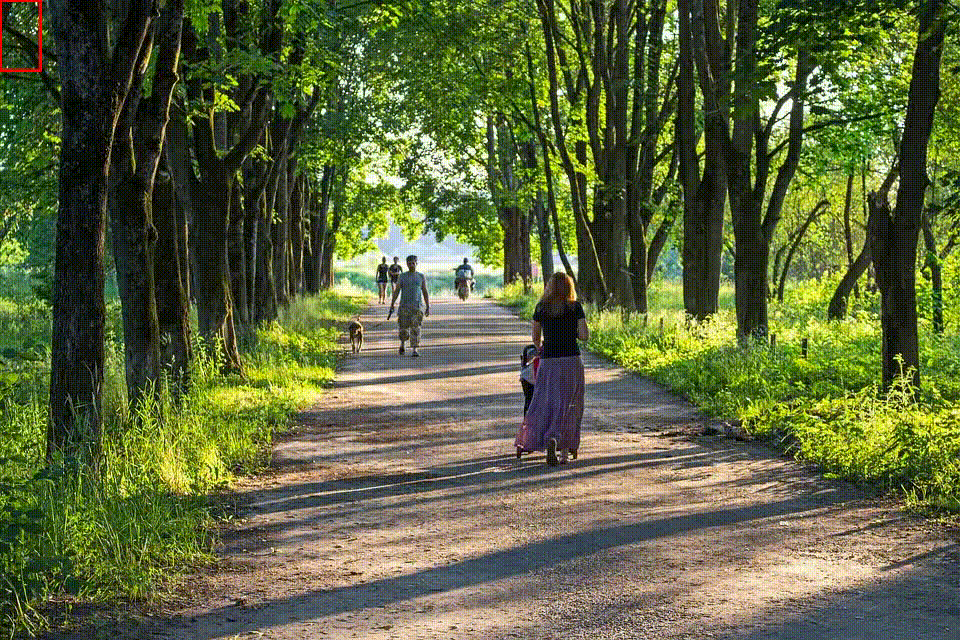

This is all good but another thing we also have to consider is that our target Object can be present at different scales in the image, consider the above image where feel further back appears smaller and people closer to the camera appear bigger, we can't classify them all with a fixed size kernel. So solution here is to go for image pyramids which resizes the image so we can detect pedestrians at different scales with the same kernel.

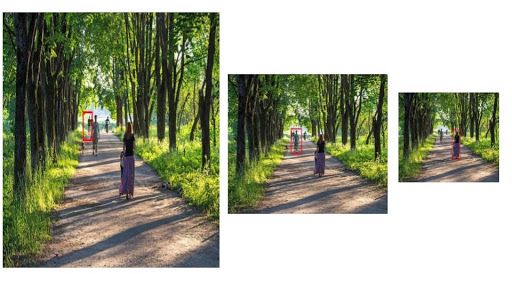

Still Target Object can have different orientations, now you could rotate the image by some angle but for now we won't worry about orientation specially since we're just dealing with standing or walking pedestrians.

## <font style="color:rgb(134,19,348)"> Detect MultiScale </font>

Now all our above requirements can be fulfilled by just using the function **`hog.detectMultiScale()`**, which takes care of making a sliding window go over the image so it can find pedestrians at different locations and it also resizes the image with `image pyramids` so it can detect pedestrians at multiple scales.

[```
(foundLocations, foundWeights) = hog.detectMultiScale(img, hitThreshold=hitThreshold, winStride=winStride, padding=padding, scale=scale,  finalThreshold=finalThreshold, useMeanshiftGrouping=useMeanshiftGrouping)]
```](https://docs.opencv.org/4.2.0/d5/d33/structcv_1_1HOGDescriptor.html#a91e56a2c317392e50fbaa2f5dc78d30b)

where

- **`img`** = Input image.

- **`foundLocations:`** Vector of rectangles where each rectangle contains the detected object.

- **`foundWeights`** =  Vector that will contain confidence values for each detected object, this can also be called the response of SVM for each object.


- **`hitThreshold`** = This is the threshold by which we say the rectangle is actually an object. The default is value is 0. all the elements in vector foundWeights will have a threshold greater than this.

- **`winStride`** = Window stride. It must be a multiple of block stride.

- **`padding`** = Padding is added to the image so the objects near the boundary can be detected. Normally its set to half of window's width. (e.g. 64/2).

- **`scale`** = This is value by which you scale down at each pyramid level, so 1.10 means you scale down by 10% at each level, so at each level you do: image = image/1.10 .

- **`finalThreshold`** = Each pedestrian can be detected multiple times, so this is a non-maximum suppression step, this parameter is used to prune all the clusters that have fewer than `final Treshold` number of rectangles.

- **`useMeanshiftGrouping`** = By default its False, this is used to group rectangles using Meanshift grouping version.

**Note:** *If weight/confidence of the detected box is greater than the hitThreshold, then we call it a detection, so with a higher hit value you can prune out weak values.*

## <font style="color:rgb(134,19,348)"> Preparing SVM for detection </font>
Now before we can use `hog.detectMultiScale()`, we first need to set our SVM detector using `hog.setSVMDetector()` using our model, unfortunately can't just pass in the model, we have to extract and format the support vectors and pass those in the setSVMDetector function.

In [12]:
# This is the required pre-processing and formating required.

support_vectors = loaded_model.getSupportVectors()
rho, _ , _ = loaded_model.getDecisionFunction(0)
Detector = np.zeros(support_vectors.shape[1] + 1, dtype = support_vectors.dtype)
Detector[:-1] = - support_vectors[:]
Detector[-1] = rho

In [13]:
# Now we can pass the detector in the svm detector function.
hog.setSVMDetector(Detector)

## <font style="color:rgb(134,19,348)">Detection Function  </font>
Now this function will detect the pedestrians, draw the bounding boxes and then return the final image.

In [14]:
def PeopleDetector(image, returndata=False, finalThreshold = 2, hitThreshold=1.1):
    
    Height = 500
    scale = Height / image.shape[0]
    image = cv2.resize(image, None, fx=scale, fy=scale)

    # Perform the Detection.
    boxes, weights = hog.detectMultiScale(image, winStride=(8, 8), padding=(32, 32), scale=1.04, 
                                         finalThreshold = finalThreshold, hitThreshold= hitThreshold)

    # Draw the Detected Boxes.
    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y), (x+w, y+h),(0, 255, 0), 2)
    
    # Either return the image or Plot it.
    if  returndata:
        return image
    
    else:
        plt.figure(figsize=[15,10])
        plt.imshow(image[:,:,::-1]);plt.axis('off');

**Check the Detector on a sample Image**

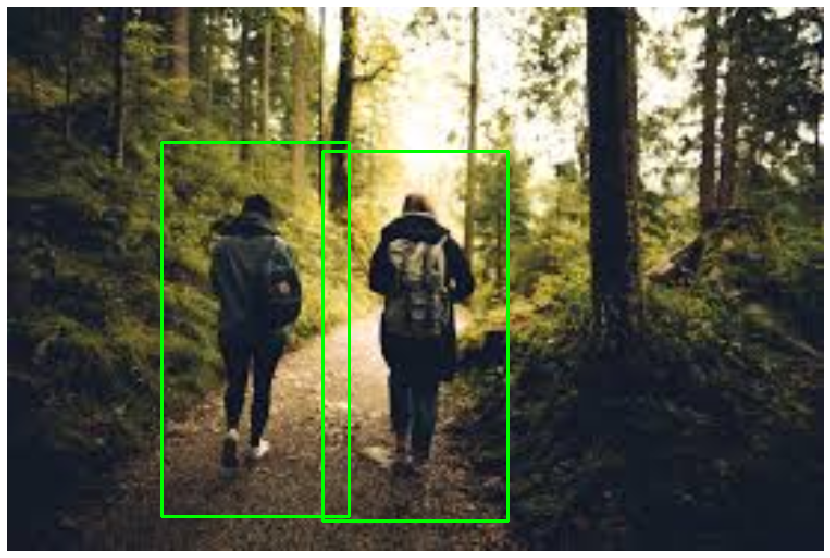

In [15]:
image = cv2.imread("Media/M4/peoplew3.jfif")
PeopleDetector(image);

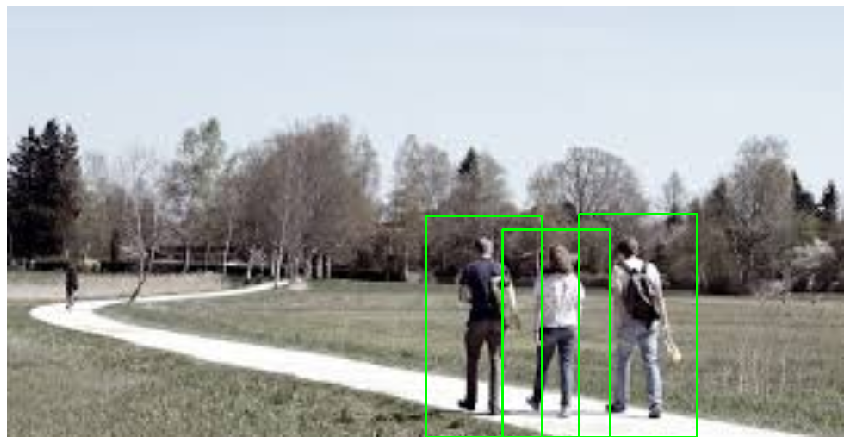

In [16]:
image = cv2.imread("Media/M4/peoplew6.jfif")
PeopleDetector(image)

## <font style="color:rgb(134,19,348)">Default People Detector with HOG  </font>
OpenCV also Implements a default People Detector which can used by passing `cv2.HOGDescriptor_getDefaultPeopleDetector()` inside the `hog.setSVMDetector()` and then using the same detection you used earlier.

In [17]:
# Initialize the Hog descriptor class
hog = cv2.HOGDescriptor()

# Load the Default People Detector
DefaultPeopleDetector = cv2.HOGDescriptor_getDefaultPeopleDetector() 

# Load the People detector
hog.setSVMDetector(DefaultPeopleDetector)

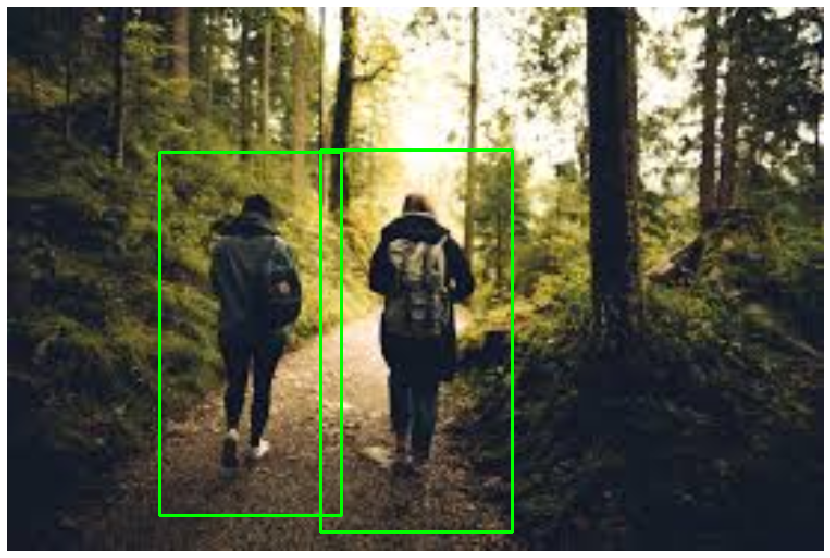

In [18]:
image = cv2.imread("Media/M4/peoplew3.jfif")
PeopleDetector(image, hitThreshold=0);

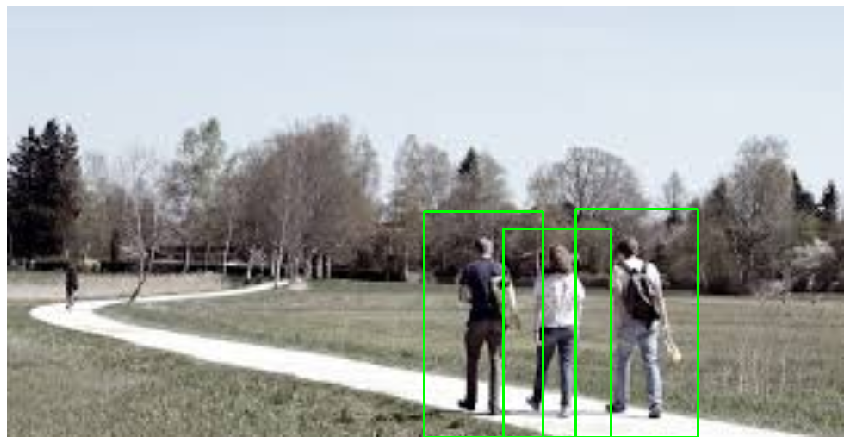

In [19]:
image = cv2.imread("Media/M4/peoplew6.jfif")
PeopleDetector(image, hitThreshold=0);

## <font style="color:rgb(134,19,348)">Detect Pedestrians on Webcam  </font>
You can use this code below to try out the detector on Real time webcam fee

In [ ]:
# Set FPS
fps= 0

cap = cv2.VideoCapture(0)

while(True):    
    # Note the start time
    start_time = time.time()
    
    ret,frame=cap.read() 
    if not ret:
        break
        
    frame = cv2.flip(frame,1) 
    
    # Select return = True sine you want the image back.
    frame = PeopleDetector(frame, returndata=True)
    
    # Put the FPS on the Screen.
    cv2.putText(frame, 'FPS: {:.2f}'.format(fps), (400, 20), cv2.FONT_HERSHEY_SIMPLEX,0.8, (255, 20, 55), 2)
    
    cv2.imshow("Image", frame)
    k = cv2.waitKey(1)
    
    # Calculate Fps
    fps= (1.0 / (time.time() - start_time))
    
    if k == ord('q'): 
            break
        
cap.release() 
cv2.destroyAllWindows()

###  <font style="color:rgb(34,169,134)"> Assignment: Build Your Own Object Detector </font>
Your task is to train an Object detector on your own dataset, maybe try making a hand detector, remember to collect relevant negative samples too.